In [172]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()
%matplotlib inline

In [173]:
#%unload_ext vimception


In [174]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import pandas as pd
import numpy as np
import netCDF4
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import *

In [175]:
year = 1998
filename='/Users/ptg21/data/projects/TRANSCOM/N96_results/CH2Br2_'+str(year)+'.nc'
ncfile1    = netCDF4.Dataset(filename)
lon1        = ncfile1.variables['longitude'][:]
lat1        = ncfile1.variables['latitude'][:] 
times1      = ncfile1.variables['t']
hybrid_ht1  = ncfile1.variables['hybrid_ht'][:]
jrates      = ncfile1.variables['field34065'][:,:,:,:]
nmonths, nlevels, ny1, nx1 = np.shape(jrates)
new_jrates = np.empty_like(jrates)
new_jrates_int = np.empty_like(jrates)
new_jrates[:,:,:,:] = jrates[:,:,:,:]
# for ivar in range (0, ny1):
#         new_jrates_int [:,:,ivar,:] = jrates[:,:, (ny1-1)-ivar,:]
        
# for ivar in range (0,nlevels):
#     new_jrates [:,ivar,:,:] = new_jrates_int[:,nlevels-ivar-1,:,:]

#nboundaries = nlevels + 1
#nx1 = len(lon1)
#ny1 = len(lat1)

In [176]:
# filename='/Users/ptg21/data/projects/TRANSCOM/ancil_creation/jrates/ch2br2_jrates_pressure_field_regrid_N96.nc'
# ncfile2     = netCDF4.Dataset(filename)
# lon2        = ncfile2.variables['longitude'][:]
# lat2        = ncfile2.variables['latitude'][:] 
# times2      = ncfile2.variables['tim']
# pressure    = ncfile2.variables['Pressure'][:]

# nx2 = len(lon2)
# ny2 = len(lat2)
# pressure_int = np.empty_like(pressure)

# #for ivar in range (0,ny2):
# #    pressure_int [:,:,ivar,:] = pressure[:,:,ny2-ivar-1,:]

# pressure = np.empty_like(pressure)    

# #for ivar in range (0,nlevels):
# #    pressure [:,ivar,:,:] = pressure_int[:,nlevels-ivar-1,:,:]

# pressure of original field = pressure
# data file to be reinterpolated = new_hrates

In [177]:
# get file containing heights, pressures for L85 ancil
filename='/Users/ptg21/data/projects/TRANSCOM/N96_ancil_creation/xkawa.p.avg2000.nc'
ncfile2     = netCDF4.Dataset(filename)

lon2        = ncfile2.variables['longitude'][:]
lat2        = ncfile2.variables['latitude'][:]
pressure    = ncfile2.variables['p'][:]

hybrid_ht2   = ncfile2.variables['hybrid_ht'][:]
times3      = ncfile2.variables['time']
nmonths2, nheights2, ny2, nx2 = np.shape(pressure)


<matplotlib.colorbar.Colorbar instance at 0x14bb349e0>

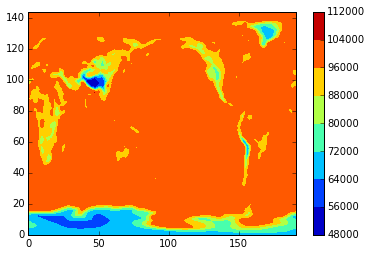

In [178]:

plt.contourf(pressure[0,0,:,:])
plt.colorbar()

In [179]:
# print (hybrid_ht2)
# print (hybrid_ht1-hybrid_ht2)
# same hybrid hts
press = np.array([1000,950,900,850,700,500,400,300,250,200,150,100,70,50,30,20,10])*100
nplevs= len(press)

In [181]:
err_str=''
nmonths,nlevels,ny1,nx1=np.shape(new_jrates)
OHres=np.zeros([nmonths, 17, ny2, nx2])
OHres_ht=np.zeros([nmonths, 17, ny2, nx2])



nyl=0
nyu=ny1

nxl=0
nxu=nx1


for imonth in range (0, nmonths):
    print imonth
    for ilat in range(nyl, nyu):
        #print ilat
        for ilon in range (nxl, nxu):
            pold = pressure[imonth,:,ilat,ilon]
            pnew = press  
            # vals to be interpolated
            vals = new_jrates[imonth, :, ilat, ilon]
            # array for interpolated data
            res = np.zeros(17)
                # for each new level, find corresponding pressure levels and interpolate OH concentration
                # need to check the case that there are two levels between the old levels.  think i did this!
            startlev=0
            # loop over levels required
            for newlev in range(0, len(pnew)):
                    found = False
                    for oldlev in range(startlev, len(pold)-1):
                        #print pnew[newlev], pold[newlev]
                        #print startlev
                        if pnew[newlev] < pold[oldlev] and pnew[newlev] >= pold[oldlev+1]:
                            # calculate gradient over this interval, pold[lev] to pold[lev+1]
                            grad = (vals[oldlev]-vals[oldlev+1])/(pold[oldlev]-pold[oldlev+1])
                            # calculate a value at thew intermediate pressure
                            val_at_newlev=vals[oldlev]+grad*(pnew[newlev]-pold[oldlev])            
                            # print str(pnew[newlev])+ 'Pa  lies between '+ str(pold[oldlev])+' and ' +str(pold[oldlev+1])+ ' Pa and corresponds to a height of ' + str(pnew[newlev]) +' m'#+ ' extrapolated value', val_at_newlev
                            # print 'JRATE at this point', val_at_newlev,' between', vals[oldlev], 'at ', pold[oldlev], 'and ', pold[oldlev+1], vals[oldlev], '\n'
                            res[newlev] = val_at_newlev
                            #print res[newlev], val_at_newlev
                            # print 'record added to',newlev
                            found = True
                            startlev = oldlev
                    if found == False:
                        #print "not found", pnew[newlev], pold.min()
                        if pnew[newlev]< pold.min():
                            # the pressure of the new level is too low, ie at the top of the atm where photolysis is high
                            # print "low", newlev
                            res[newlev] = vals.max()
                            found = True
                        elif pnew[newlev] > pold.max():
                            # the pressure of the new level is too high, ie at the bottom of the atm where photolysis is low
                            # print "high", newlev, pnew[newlev], pold.max()
                            res[newlev]  = -999.
                            found = True
            # add the results to the output array
            # print (OHres_ht[imonth, :, ilat, ilon])
            OHres_ht[imonth, :, ilat, ilon] = res

0
1
2
3
4
5
6
7
8
9
10
11


In [183]:
# finish me and start from here!!

In [184]:
np.save('interp_ch2br2_res'+str(year)+'.npy',OHres_ht)

In [185]:
interp_ch2br2_rates=np.load('interp_ch2br2_res'+str(year)+'.npy')

In [186]:
interp_ch2br2_rates[interp_ch2br2_rates<1e-20] = -999

In [187]:
from netcdftime import utime, JulianDayFromDate,DateFromJulianDay, date2index
from netcdftime import datetime as datetimex, date2num
from netCDF4 import Dataset
import time

# create a series of dates for the netcdf file in times.
from datetime import datetime, timedelta

# this fix if times already created!
try:
    times  = dataset.createDimension('time',      None)
except:
     None   

# ditto
try:
    times  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below
except:
    None
    
times.standard_name = 'time'
times.long_name = 'time'
times.units = 'days since 1991-09-01 00:00:00'
times.calendar = '360_day'

dates = []
for n in range (0,12):
    # nasty fix for the fact that datetime.timedelta only works on 365 day calendar
    new_date =  date2num(datetime(year,1,16),units=times1.units, calendar=times1.calendar)+n*30
    dates.append(num2date(new_date, units=times1.units, calendar=times1.calendar))


times[:] = date2num(dates,units=times.units,calendar=times.calendar)

print 'time values (in units %s): ' % times.units+'\n',times[:]

time values (in units days since 1991-09-01 00:00:00): 
[ 2295.  2325.  2355.  2385.  2415.  2445.  2475.  2505.  2535.  2565.
  2595.  2625.]


In [188]:
%%bash
rm -Rf N96_L85_1998_ch2br2.nc

In [189]:
from netCDF4 import Dataset
import time
# Create HDF5 *format*, classic *model*
dataset = Dataset('N96_L85_1998_ch2br2.nc', 'w', format='NETCDF4')

# Global Attributes
dataset.description = 'TEST NETCDF-CF COMPLIANT SCRIPT'
dataset.history = 'Created ' + time.ctime(time.time())
dataset.source = ''
dataset.Conventions = 'CF-1.0'
dataset.standard_name_vocabulary='CF-1.0'

height = dataset.createDimension('pressure', nplevs)
height = dataset.createVariable('pressure',  np.int32,   ('pressure',))

time  = dataset.createDimension('time',      None)
time  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below

lat   = dataset.createDimension('latitude',  ny1)
lat   = dataset.createVariable('latitude',   np.float32, ('latitude',))

lon   = dataset.createDimension('longitude', nx1)
lon   = dataset.createVariable('longitude',  np.float32, ('longitude',))

jrates         = dataset.createVariable('jrate', np.float32, ('time','pressure','latitude', 'longitude',), fill_value=-999.)

lon[:]   = lon1[:]
lat[:]   = lat1[:]
height[:] = press[:]
time[:]  = times[:]

jrates[:,:,:,:] = interp_ch2br2_rates[:,:,:,:]

# Variable Attributes
lat.standard_name = 'latitude'
lat.units = 'degrees_north'
lat.cartesian_axis = "Y"
lat.axis = 'Y'
lat.actual_range = -90.0, 90.0

lon.standard_name = 'longitude'
lon.units = 'degrees_east'
lon.cartesian_axis = "X"
lon.axis = "X"
lat.actual_range = 0.0, 360.0

jrates.units = 's-1'
jrates.standard_name='Ch2Br2 mass mixing ratio'
#jrates._FillValue = -999
#jrates.missing_value = -999

height.units = 'mbar'
height.axis='Z'
height.positive='up'
height.standard_name = 'pressure_levels'


time.standard_name = 'time'
time.long_name = 'time'
time.units = 'days since 1991-12-01 00:00:00'
time.calendar = '360_day'
time.axis = 'T'
print ('success')
dataset.close()

success


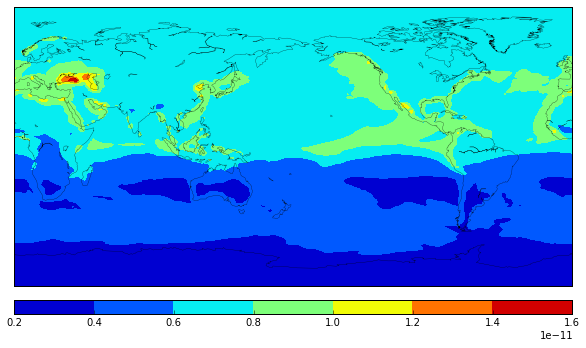

In [45]:
# check plot for comp with ncview create the figure and axes instances.
fig = plt.figure(num=2,figsize=(10,15),dpi=300)
zvar=0
m1 = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,llcrnrlon=0,urcrnrlon=360.,resolution='c')
lons1, lats1 = m1.makegrid(nx2, ny2)
x1,y1 = m1(lons1, lats1)
im1 = m1.contourf(x1, y1, new_jrates[0,0,:,:])
m1.colorbar(im1,location='bottom',pad="5%")
m1.drawcoastlines(linewidth=0.25)


<matplotlib.colorbar.Colorbar instance at 0x2b767027d248>

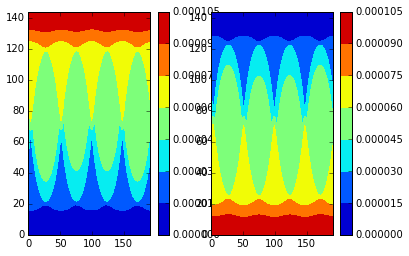

In [71]:
plt.subplot(1,2,1)
plt.contourf(jrates[0,0,:,:])
plt.colorbar()
plt.subplot(1,2,2)
plt.contourf(new_jrates[0,-1,:,:])
plt.colorbar()
#plt.plot(OHres_ht[0,:,1,15])

<matplotlib.colorbar.Colorbar instance at 0x2b766fc35dd0>

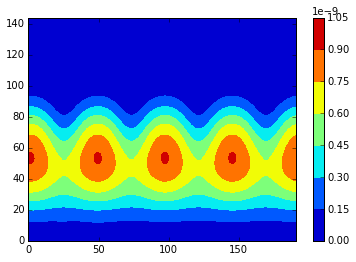

In [67]:
plt.contourf(new_jrates[11,0,:,:])
plt.colorbar()

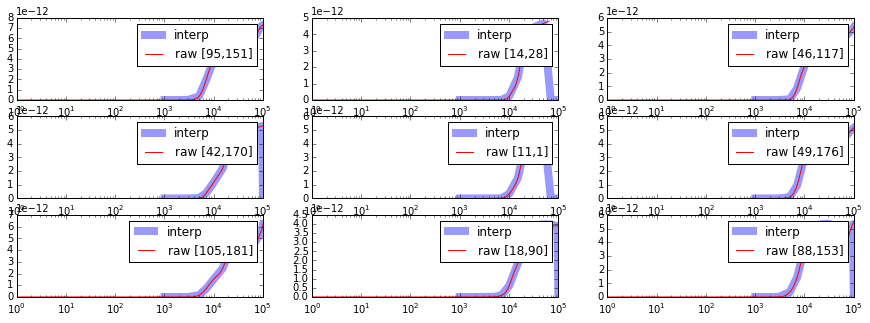

In [86]:
from random import randint

plt.figure(figsize=(15,5))

for ivar in range (1,10):
    plt.subplot(3,3,ivar)
    month=randint(0,11)
    lat=randint(0,ny1-1)
    lon=randint(0,nx1-1)
    plt.semilogx(press[:],interp_ch2br2_rates[month,:,lat,lon], lw=8, alpha=0.4, label='interp')
    plt.semilogx(pressure[month,:,lat,lon],new_jrates[month,:,lat,lon],'r-', label='raw [' + str(lat)+","+str(lon)+"]")
    plt.xlim([1,1e5])
    plt.legend()